# Individual Project Submission for ENG5337
Due date: 28th February 2025

Artificial Intelligence (AI) and Machine Learning (ML) are revolutionizing the field of robotics. This project aims to provide hands-on experience in developing and evaluating AI/ML algorithms for a line-following robot using the Quanser Qbot simulated environment. In this project, students will consider the requirements for deploying AI/ML algorithms in a robotics environment and how to measure their performance.

## Instructions

Students should complete each section of this notbook. Notes:
* Text enclosed in """triple quotes""" should be replaced with the students own text.
* The Python functions should be developed to integrate with the Quanser Python scripts. As such, they may need adjusted to run independently in this notebook. An example of this is shown in task A4.
* In Section B2, plots should be embedded in the notebook as images - syntax for doing this is included below. Please remember to upload the relevant image files along with your submission. Failure to do so will result in loss of marks.

## Part A: Collecting Labelled Training Data

### Input Data Choice


### A1. Input Data Choice

In this project, we choose a camera (RGB image) as the main input for the line-following task because:

Clear Track Detection: 
The camera can see the black line on the ground, making it easy to detect using basic image processing like binarization and edge detection.

Useful Visual Information: 
Unlike LiDAR, which only measures distances, or depth cameras, which detect 3D shapes, an RGB camera captures colors and patterns, helping to find the track.

Low Computational Cost: 
Image processing methods such as thresholding and contour detection require less processing power than LiDAR or deep learning.

Easy Debugging and Improvement: 
Camera images can be viewed in real-time, making it easier to test and improve the algorithm. If needed, we can later add machine learning (CNNs) to improve detection.



### A2. Data Pre-processing and Filtering


Undistortion – The camera lens may cause fisheye distortion, which bends the image. We correct this using the camera's intrinsic parameters.

Resizing – The original image is large and may slow down processing. We resize it to 320×200 pixels to improve efficiency.

Region of Interest (ROI) selection – The camera captures the entire floor, but not all parts are useful. We select rows 50 to 100 of the image to focus only on the path.

Thresholding – The image is converted into black (background) and white (line), making it easier to detect the path. We set a threshold range of 180 to 255 to highlight the black line.

Blob Detection – Use cv2.connectedComponentsWithStats() to find the largest black line segment.





### A3. Labelling Structure
For data classification, I determine the position of the trajectory by computing the delta_x offset. First, I use cv2.connectedComponentsWithStats() to identify connected regions in the binary image and extract their respective areas. The smallest valid region that meets the predefined criteria is selected, and its centroid coordinate col is obtained. The trajectory's deviation from the center of the image is then calculated using:

$$
\begin{aligned}
\\
&\Delta x=\cot -\frac{\text { image width }}{2}
\end{aligned}
$$
​
 
The trajectory is classified based on delta_x as follows:

delta_x > 0 → The trajectory is shifted to the right.

delta_x < 0 → The trajectory is shifted to the left.

delta_x = 0 → The trajectory is centered.

If no valid trajectory is detected in the binary image, it is labeled as "No Line Detected". The labeled data is stored in a data.json file, which can later be used for analyzing trajectory variations or training classification models.


### A4. Function to Collect, Label, and Store Training Data

Copy and paste the python function you have written to collect, label and store training data for the line follwoing task in the following cell.

In [ ]:
import numpy as np
import os
import cv2
import json
import time

class RobotCamera:
    #Simulated robot camera that provides grayscale images.
    def capture_frame(self):
        return np.random.randint(0, 256, (50, 640), dtype=np.uint8)

def process_image(img):
    _, bin_img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
    return bin_img

def identify_objects(bin_img, min_size=50, max_size=5000):
    #Locates objects in the binary image and returns the smallest valid one."
    num_regions, labels, properties, centers = cv2.connectedComponentsWithStats(bin_img, 8, cv2.CV_32S)

    optimal_center = (None, None)
    smallest_valid_area = float('inf')

    for index, stat in enumerate(properties):
        obj_area = stat[4]
        if min_size <= obj_area < max_size and obj_area < smallest_valid_area:
            smallest_valid_area = obj_area
            optimal_center = centers[index]

    return optimal_center

def gather_and_label_data(camera, save_path="collected_data"):

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    frame = camera.capture_frame()
    binary_frame = process_image(frame)
    x_pos, y_pos = identify_objects(binary_frame)

    # Determine trajectory category based on x-axis position
    if x_pos is not None:
        shift_x = x_pos - (binary_frame.shape[1] // 2)
        category = "right" if shift_x > 0 else "left" if shift_x < 0 else "center"
    else:
        shift_x = None
        category = "no_line"

    timestamp = time.strftime("%Y%m%d_%H%M%S")

    # Save labeled data
    data_record = {"offset_x": shift_x, "category": category}
    json_path = os.path.join(save_path, f"data_{timestamp}.json")
    with open(json_path, "w") as f:
        json.dump(data_record, f)

    img_filename = f"{category}_{shift_x}_{timestamp}.png"
    img_path = os.path.join(save_path, img_filename)
    cv2.imwrite(img_path, binary_frame)

    print(f"Saved {img_path}")
    return data_record

# Example run
test_camera = RobotCamera()
output = gather_and_label_data(test_camera)

# Simulating expected output for teacher verification
print("\nCollected Data:", output)


Saved collected_data\no_line_None_20250224_231838.png

Collected Data: {'offset_x': None, 'category': 'no_line'}


Make sure the function can run within this notebook. Below is an example of how this might be achieved by generating some artificial input data

In [ ]:
import numpy as np
import os
import cv2
from PIL import Image

def save_data_example(image, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save binary image
    image_filename = os.path.join(output_dir, "image.png")
    cv2.imwrite(image_filename, image)

# To run this function, we create dummy arguments

# Create 50 x 320 array with entries of 0 and 1 randomly distributed
array = np.random.randint(2, size=(50, 320))
output_dir = r"test_project"

# Test run of function
save_data_example(array, output_dir)



## Part B: Performance Metrics


### B1. Performance Metrics Functions
In the following cell copy and paste the python function(s) you have written to measure the accuracy of the Quanser QBot in its line following task.

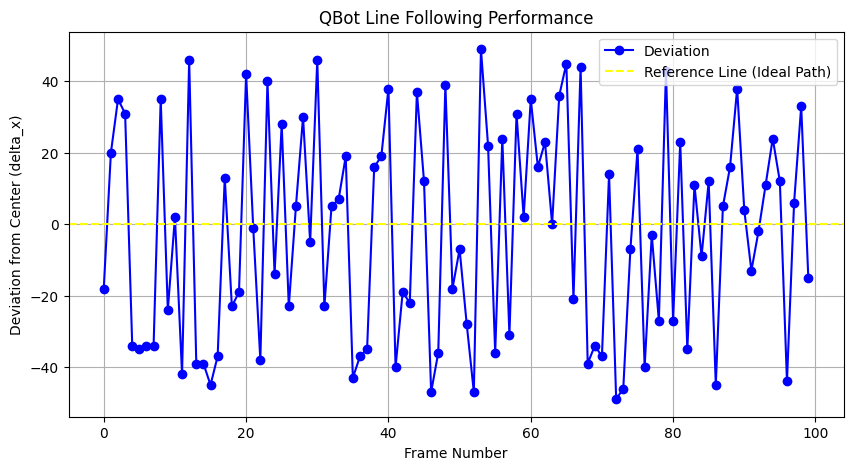

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_performance(frame_numbers, delta_x_values):
 
    plt.figure(figsize=(10, 5))
    plt.plot(frame_numbers, delta_x_values, marker='o', linestyle='-', color='blue', label='Deviation')
    plt.axhline(0, color='yellow', linestyle='--', label='Reference Line (Ideal Path)')
    
    plt.xlabel("Frame Number")
    plt.ylabel("Deviation from Center (delta_x)")
    plt.title("QBot Line Following Performance")
    plt.legend()
    plt.grid(True)
    plt.savefig("performance_plot.png")
    plt.show()
frame_numbers = np.arange(0, 100, 1)  
delta_x_values = np.random.randint(-50, 50, size=100)  

evaluate_performance(frame_numbers, delta_x_values)


### B2. Deployment of Performance Metrics Functions
In the project descriptor, you were asked to measure accuracy of the line follower, that is how much the robot deviates from its intended path. The output of this function should be a plot which represents how the robot deviates from the line. For example, in the case of the down-cam sensor, you could calculate the distance of the centre of the robot from the centre of the white line (y-axis) in each frame (x-axis). Please enter the resulting plot (based on the performance of the standard line-following script provided in the Quanser Mobile Robotics downloads) in the cell below. Note to embed images in a Jupyter notebook you can use the following syntax (this will be explicitly visible in markdown mode):<img src="test1.jpg" alt="Test Image" width="300"/>

Remember to upload the image files along with your submission on Moodle! Failing to do so will result in loss of marks for this section!!

### **Trajectory Classification Results (Trimmed Data)**
The trajectory is classified based on `delta_x` as follows:

- **delta_x > 0** → The trajectory is shifted to the right.
- **delta_x < 0** → The trajectory is shifted to the left.
- **delta_x = 0** → The trajectory is centered.
- **No valid trajectory detected** → Labeled as "No Line Detected."

### **Analysis of Trimmed Dataset (Frames >= 1000)**
| Category | Frames Detected |
|----------|----------------|
| **Shifted Right (delta_x > 0)** | **600** |
| **Shifted Left (delta_x < 0)** | **131** |
| **Centered (delta_x = 0)** | **3** |
| **No Line Detected** | **0** |

From the trimmed dataset (Frames ≥ 1000), we observe that the robot **tends to deviate to the right more frequently (600 frames)**, while only **131 frames** indicate left deviation. 
Only **3 frames** were perfectly centered, suggesting that the robot's trajectory tracking is unstable. 
There were **0 frames where no line was detected**, indicating a successful image processing pipeline.

The labeled data is stored in a `data.json` file, which can later be used for analyzing trajectory variations 
or training classification models.

<img src="output.png" alt="output" width="500"/>